In [2]:
import fcalc
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import time
from tqdm import tqdm, trange
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Parameters search

In [3]:
def model_test_CV(X, y, cat_cols=None, method="standard", alpha=0.,
                  randomize=False, num_iters=10, subsample_size=1e-2,
                  kde_bandwidth=1.0, kde_kernel='gaussian', kde_leaf_size=40,
                  kde_classwise=False, scale_density=True, n_splits=5, seed=42):
    kf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
    Accuracy = []
    F1_score = []
    Unclassified = []
    exec_time = []
    for train_index, test_index in kf.split(X):
        pat_cls = fcalc.classifier.PatternClassifier(X[train_index], y[train_index], 
                                                     categorical=cat_cols, method=method,
                                                     alpha=alpha, randomize=randomize, num_iters=num_iters,
                                                     subsample_size=subsample_size, kde_bandwidth=kde_bandwidth,
                                                     kde_kernel=kde_kernel, kde_leaf_size=kde_leaf_size,
                                                     kde_classwise=kde_classwise, scale_density=scale_density)
        start = time.time()
        pat_cls.predict(X[test_index])
        end = time.time()
        Accuracy.append(accuracy_score(y[test_index], pat_cls.predictions))
        F1_score.append(f1_score(y[test_index], pat_cls.predictions, average='macro'))
        Unclassified.append((pat_cls.predictions==-1).sum()/pat_cls.predictions.shape[0])
        exec_time.append(end-start)
    
    Accuracy.append(np.mean(Accuracy)); F1_score.append(np.mean(F1_score))
    Unclassified.append(np.mean(Unclassified)); exec_time.append(np.mean(exec_time))
    return pd.DataFrame(zip(Accuracy,F1_score,Unclassified,exec_time),
                        columns=["Accuracy","F1 score", "Unclassified", "time (sec.)"],
                        index=[x+1 for x in range(kf.get_n_splits())]+["mean"])

## Iris

In [4]:
df = pd.read_csv('data_sets/iris.data', names=['sepal_length',	'sepal_width',	'petal_length',	'petal_width','species'])
le = LabelEncoder(); le.fit(df["species"].values)
df["species"] = le.transform(df["species"].values)
X_train = df.drop('species', axis=1).values
y_train = df['species'].values
n_iters = np.arange(10,51,10)
s_size = np.arange(1,11) #np.linspace(1e-2,5e-2,num=5,endpoint=True)
result = []
for n in n_iters:
    for s in s_size:
        res = model_test_CV(X_train,y_train,randomize=True,num_iters=n,subsample_size=s)
        result.append(res.loc["mean"].values)
result=pd.DataFrame(result,columns=["Accuracy","F1 score", "Unclassified","time (sec.)"], 
                    index=pd.MultiIndex.from_product([n_iters, s_size], names=["Number of iterations","Subsample size"]))
result[["Accuracy", "F1 score", "Unclassified"]] = result[["Accuracy", "F1 score", "Unclassified"]].round(4)
result["time (sec.)"] = result["time (sec.)"].round(2)
display(result)
result.to_csv("D:/University/masters thesis/csv results/iris_random_res_multiindex.csv", index=True,
              index_label=["Number of iterations","Subsample size"])

Accuracy  F1 score  Unclassified  \
Number of iterations Subsample size                                     
10                   0.01              0.8267    0.6674        0.1533   
                     0.02              0.8267    0.6674        0.1533   
                     0.03              0.9000    0.7266        0.0333   
                     0.04              0.9000    0.7266        0.0333   
                     0.05              0.8800    0.6762        0.0600   
20                   0.01              0.8600    0.6793        0.1067   
                     0.02              0.8600    0.6793        0.1067   
                     0.03              0.9133    0.8667        0.0133   
                     0.04              0.9133    0.8667        0.0133   
                     0.05              0.9067    0.7368        0.0333   
30                   0.01              0.9067    0.7519        0.0600   
                     0.02              0.9067    0.7519        0.0600   
                     0.03              0.9133    0.8667        0.0133   
                     0.04              0.9133    0.8667        0.0133   
                     0.05              0.9133    0.8651        0.0067   
40                   0.01              0.9133    0.7521        0.0467   
                     0.02              0.9133    0.7521        0.0467   
                     0.03              0.9133    0.8675        0.0133   
                     0.04              0.9133    0.8675        0.0133   
                     0.05              0.9133    0.9094        0.0000   
50                   0.01              0.9133    0.7521        0.0467   
                     0.02              0.9133    0.7521        0.0467   
                     0.03              0.9267    0.8825        0.0067   
                     0.04              0.9267    0.8825        0.0067   
                     0.05              0.9133    0.8651        0.0067   

                                     time (sec.)  
Number of iterations Subsample size               
10                   0.01                   0.04  
                     0.02                   0.05  
                     0.03                   0.04  
                     0.04                   0.04  
                     0.05                   0.05  
20                   0.01                   0.08  
                     0.02                   0.11  
                     0.03                   0.08  
                     0.04                   0.08  
                     0.05                   0.08  
30                   0.01                   0.14  
                     0.02                   0.11  
                     0.03                   0.11  
                     0.04                   0.11  
                     0.05                   0.11  
40                   0.01                   0.15  
                     0.02                   0.14  
                     0.03                   0.15  
                     0.04                   0.15  
                     0.05                   0.15  
50                   0.01                   0.18  
                     0.02                   0.18  
                     0.03                   0.18  
                     0.04                   0.18  
                     0.05                   0.18

## Red wine

In [5]:
winered_df = pd.read_csv("data_sets/winequality-red.csv",sep=";")
X_train = winered_df.drop("quality",axis=1).values
y_train = winered_df["quality"].values
n_iters = np.arange(10,51,10)
s_size = np.linspace(1e-2,5e-2,num=5,endpoint=True) #np.arange(1,6) 
result = []
for n in n_iters:
    for s in s_size:
        res = model_test_CV(X_train,y_train,randomize=True,num_iters=n,subsample_size=s)
        result.append(res.loc["mean"].values)
result=pd.DataFrame(result,columns=["Accuracy","F1 score", "Unclassified", "time (sec.)"], 
                    index=pd.MultiIndex.from_product([n_iters, s_size], names=["Number of iterations","Subsample size"]))
result[["Accuracy", "F1 score", "Unclassified"]] = result[["Accuracy", "F1 score", "Unclassified"]].round(4)
result["time (sec.)"] = result["time (sec.)"].round(2)
display(result)
result.to_csv("D:/University/masters thesis/csv results/wine_random_res_multiindex.csv", index=True,
              index_label=["Number of iterations","Subsample size"])

Accuracy  F1 score  Unclassified  \
Number of iterations Subsample size                                     
10                   0.01              0.0388    0.0739        0.6448   
                     0.02              0.0206    0.0440        0.6573   
                     0.03              0.0094    0.0135        0.4753   
                     0.04              0.0069    0.0080        0.4778   
                     0.05              0.0069    0.0080        0.4759   
20                   0.01              0.0425    0.0761        0.5235   
                     0.02              0.0275    0.0518        0.5378   
                     0.03              0.0113    0.0139        0.4102   
                     0.04              0.0088    0.0084        0.4127   
                     0.05              0.0088    0.0084        0.4121   
30                   0.01              0.0456    0.0773        0.4547   
                     0.02              0.0344    0.0614        0.4653   
                     0.03              0.0156    0.0207        0.3827   
                     0.04              0.0100    0.0091        0.3883   
                     0.05              0.0100    0.0091        0.3883   
40                   0.01              0.0475    0.0754        0.4228   
                     0.02              0.0344    0.0599        0.4353   
                     0.03              0.0213    0.0290        0.3640   
                     0.04              0.0119    0.0106        0.3733   
                     0.05              0.0119    0.0106        0.3733   
50                   0.01              0.0513    0.0813        0.4065   
                     0.02              0.0406    0.0703        0.4165   
                     0.03              0.0244    0.0355        0.3583   
                     0.04              0.0119    0.0105        0.3708   
                     0.05              0.0119    0.0105        0.3708   

                                     time (sec.)  
Number of iterations Subsample size               
10                   0.01                   2.39  
                     0.02                   2.26  
                     0.03                   2.23  
                     0.04                   2.20  
                     0.05                   2.23  
20                   0.01                   4.39  
                     0.02                   4.32  
                     0.03                   4.35  
                     0.04                   4.36  
                     0.05                   4.36  
30                   0.01                   7.09  
                     0.02                   6.80  
                     0.03                   6.74  
                     0.04                   6.62  
                     0.05                   6.60  
40                   0.01                   9.03  
                     0.02                   9.00  
                     0.03                   8.96  
                     0.04                   8.44  
                     0.05                   9.26  
50                   0.01                  11.30  
                     0.02                  11.29  
                     0.03                  12.09  
                     0.04                  11.33  
                     0.05                  11.66

## Red wine binary

In [7]:
winered_bin_df = pd.read_csv("data_sets/winequality-red-bin.csv")
le = LabelEncoder(); le.fit(winered_bin_df["quality"].values)
winered_bin_df["quality"] = le.transform(winered_bin_df["quality"].values)
X_train = winered_bin_df.drop("quality",axis=1).values
y_train = winered_bin_df["quality"].values
n_iters = np.arange(10,51,10)
s_size = np.linspace(1e-3,5e-3,num=5,endpoint=True) #np.arange(1,11) 
result = []
for n in n_iters:
    for s in tqdm(s_size, total=s_size.shape[0], desc=f"n_iters: {n}", leave=False):
        res = model_test_CV(X_train,y_train,randomize=True,num_iters=n,subsample_size=s)
        result.append(res.loc["mean"].values)
result=pd.DataFrame(result,columns=["Accuracy","F1 score", "Unclassified", "time (sec.)"], 
                    index=pd.MultiIndex.from_product([n_iters, s_size], names=["Number of iterations","Subsample size"]))
result[["Accuracy", "F1 score", "Unclassified"]] = result[["Accuracy", "F1 score", "Unclassified"]].round(4)
result["time (sec.)"] = result["time (sec.)"].round(2)
display(result)
result.to_csv("D:/University/masters thesis/csv results/wine_bin_random_res_multiindex.csv", index=True,
              index_label=["Number of iterations","Subsample size"])

Accuracy  F1 score  Unclassified  \
Number of iterations Subsample size                                     
10                   0.001             0.4559    0.3890        0.4434   
                     0.002             0.6961    0.4743        0.0801   
                     0.003             0.6460    0.4257        0.0607   
                     0.004             0.6341    0.4340        0.1458   
                     0.005             0.4883    0.3785        0.3679   
20                   0.001             0.5541    0.4305        0.3027   
                     0.002             0.7549    0.5056        0.0394   
                     0.003             0.6904    0.4559        0.0294   
                     0.004             0.6998    0.4700        0.0788   
                     0.005             0.6078    0.4418        0.2221   
30                   0.001             0.5998    0.4460        0.2333   
                     0.002             0.7636    0.5090        0.0269   
                     0.003             0.6947    0.4606        0.0281   
                     0.004             0.7286    0.4834        0.0444   
                     0.005             0.6666    0.4730        0.1639   
40                   0.001             0.6429    0.4622        0.1726   
                     0.002             0.7787    0.5181        0.0200   
                     0.003             0.6947    0.4567        0.0188   
                     0.004             0.7336    0.4870        0.0413   
                     0.005             0.6892    0.4776        0.1208   
50                   0.001             0.6698    0.4743        0.1382   
                     0.002             0.7768    0.5160        0.0213   
                     0.003             0.6804    0.4451        0.0181   
                     0.004             0.7493    0.4957        0.0269   
                     0.005             0.7086    0.4916        0.1007   

                                     time (sec.)  
Number of iterations Subsample size               
10                   0.001                  0.88  
                     0.002                  0.89  
                     0.003                  0.83  
                     0.004                  0.84  
                     0.005                  0.87  
20                   0.001                  1.75  
                     0.002                  1.63  
                     0.003                  1.69  
                     0.004                  1.69  
                     0.005                  1.75  
30                   0.001                  2.43  
                     0.002                  2.62  
                     0.003                  2.49  
                     0.004                  2.54  
                     0.005                  2.62  
40                   0.001                  3.30  
                     0.002                  3.38  
                     0.003                  3.47  
                     0.004                  3.13  
                     0.005                  3.18  
50                   0.001                  4.17  
                     0.002                  3.72  
                     0.003                  3.79  
                     0.004                  3.77  
                     0.005                  3.77

# Stability test

## Iris

In [16]:
n_iters = np.arange(10,51,10)
s_size = np.arange(1,11)
seeds = np.arange(100)
avg_acc = np.zeros(shape=(n_iters.shape[0], s_size.shape[0]))
avg_f1 = np.zeros(shape=(n_iters.shape[0], s_size.shape[0]))
std_acc = np.zeros(shape=(n_iters.shape[0], s_size.shape[0]))
std_f1 = np.zeros(shape=(n_iters.shape[0], s_size.shape[0]))

In [17]:
df = pd.read_csv('data_sets/iris.data', names=['sepal_length',  'sepal_width',  'petal_length',  'petal_width','species'])
le = LabelEncoder(); le.fit(df["species"].values)
df["species"] = le.transform(df["species"].values)
X = df.drop('species', axis=1).values
y = df['species'].values

In [19]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
for i in range(n_iters.shape[0]):
    for j in range(s_size.shape[0]):
        acc = np.zeros_like(seeds, dtype=float)
        f1 = np.zeros_like(seeds, dtype=float)
        for k in range(seeds.shape[0]):
            Accuracy = 0.
            F1_score = 0.
            for train_index, test_index in tqdm(kf.split(X), total=kf.get_n_splits(), leave=False,
                                                desc= f"n_iters: {n_iters[i]}; s_size: {s_size[j]}; seed: {seeds[k]}"):
                pat_cls = fcalc.classifier.PatternClassifier(X[train_index], y[train_index], method='standard',
                                                             randomize=True, num_iters=n_iters[i],
                                                             subsample_size=s_size[j], seed=seeds[k])
                pat_cls.predict(X[test_index])
                Accuracy += round(accuracy_score(y[test_index], pat_cls.predictions), 4)
                F1_score += round(f1_score(y[test_index], pat_cls.predictions, average='macro'),4)
            acc[k] = Accuracy / kf.get_n_splits()
            f1[k] = F1_score / kf.get_n_splits()

        avg_acc[i][j] = acc.mean()
        avg_f1[i][j] = f1.mean()
        std_acc[i][j] = acc.std()
        std_f1[i][j] = f1.std()       


In [53]:
np.save('stability tests/iris_avg_acc.npy', avg_acc, allow_pickle=False)
np.save('stability tests/iris_avg_f1.npy', avg_f1, allow_pickle=False)
np.save('stability tests/iris_std_acc.npy', std_acc, allow_pickle=False)
np.save('stability tests/iris_std_f1.npy', std_f1, allow_pickle=False)

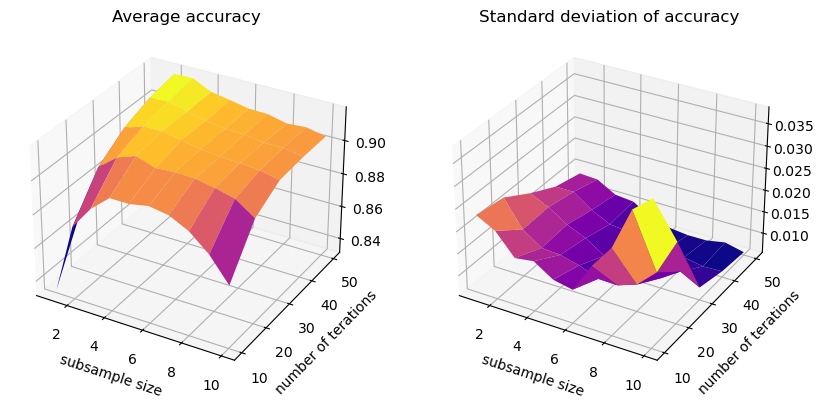

In [67]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(10,5))
x_grid, y_grid = np.meshgrid(s_size, n_iters)

ax[0].plot_surface(x_grid, y_grid, avg_acc, cmap='plasma')
ax[0].set_xlabel('subsample size')
ax[0].set_ylabel('number of terations')
ax[0].set_title('Average accuracy')

ax[1].plot_surface(x_grid, y_grid, std_acc, cmap='plasma')
ax[1].set_xlabel('subsample size')
ax[1].set_ylabel('number of terations')
ax[1].set_title('Standard deviation of accuracy')

plt.savefig('figs/iris_acc_stability.jpg')

plt.show()

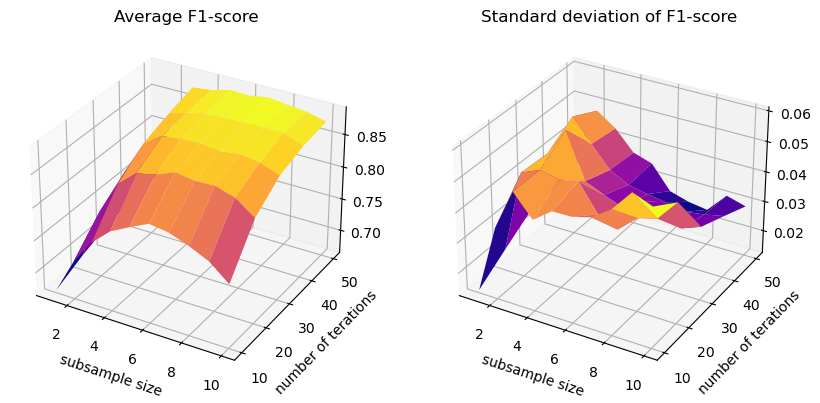

In [68]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(10,5))
x_grid, y_grid = np.meshgrid(s_size, n_iters)

ax[0].plot_surface(x_grid, y_grid, avg_f1, cmap='plasma')
ax[0].set_xlabel('subsample size')
ax[0].set_ylabel('number of terations')
ax[0].set_title('Average F1-score')

ax[1].plot_surface(x_grid, y_grid, std_f1, cmap='plasma')
ax[1].set_xlabel('subsample size')
ax[1].set_ylabel('number of terations')
ax[1].set_title('Standard deviation of F1-score')

plt.savefig('figs/iris_f1_stability.jpg')

plt.show()

## Wine

In [ ]:
n_iters = np.arange(10,51,10)
s_size = np.arange(1,6)
seeds = np.arange(100)
avg_acc = np.zeros(shape=(n_iters.shape[0], s_size.shape[0]))
avg_f1 = np.zeros(shape=(n_iters.shape[0], s_size.shape[0]))
std_acc = np.zeros(shape=(n_iters.shape[0], s_size.shape[0]))
std_f1 = np.zeros(shape=(n_iters.shape[0], s_size.shape[0]))

In [ ]:
winered_df = pd.read_csv("data_sets/winequality-red.csv",sep=";")
X = winered_df.drop("quality",axis=1).values
y = winered_df["quality"].values

In [ ]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
for i in range(n_iters.shape[0]):
    for j in range(s_size.shape[0]):
        acc = np.zeros_like(seeds, dtype=float)
        f1 = np.zeros_like(seeds, dtype=float)
        for k in range(seeds.shape[0]):
            Accuracy = 0.
            F1_score = 0.
            for train_index, test_index in tqdm(kf.split(X), total=kf.get_n_splits(), leave=False,
                                                desc= f"n_iters: {n_iters[i]}; s_size: {s_size[j]}; seed: {seeds[k]}"):
                pat_cls = fcalc.classifier.PatternClassifier(X[train_index], y[train_index], method='standard',
                                                             randomize=True, num_iters=n_iters[i],
                                                             subsample_size=s_size[j], seed=seeds[k])
                pat_cls.predict(X[test_index])
                Accuracy += round(accuracy_score(y[test_index], pat_cls.predictions), 4)
                F1_score += round(f1_score(y[test_index], pat_cls.predictions, average='macro'),4)
            acc[k] = Accuracy / kf.get_n_splits()
            f1[k] = F1_score / kf.get_n_splits()

        avg_acc[i][j] = acc.mean()
        avg_f1[i][j] = f1.mean()
        std_acc[i][j] = acc.std()
        std_f1[i][j] = f1.std()       


In [ ]:
np.save('stability tests/wine_avg_acc.npy', avg_acc, allow_pickle=False)
np.save('stability tests/wine_avg_f1.npy', avg_f1, allow_pickle=False)
np.save('stability tests/wine_std_acc.npy', std_acc, allow_pickle=False)
np.save('stability tests/wine_std_f1.npy', std_f1, allow_pickle=False)